In [2]:
import numpy as np 
import pandas as pd
import neattext.functions as nfx
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tqdm import tqdm
import pickle


In [23]:
data=pd.read_csv('./dataset/Suicide_Detection.csv')

In [25]:
train_data,test_data=train_test_split(data,test_size=0.2,random_state=10)

In [28]:
def clean_text(text):
    text_length=[]
    cleaned_text=[]
    for str in tqdm(text):
        str=str.lower()
        # str=nfx.remove_emails(str)
        # str=nfx.remove_urls(str)
        str=nfx.remove_special_characters(str)
        str=nfx.remove_stopwords(str)
        text_length.append(len(str.split()))
        cleaned_text.append(str)
    return cleaned_text,text_length

In [29]:
cleaned_train_text, train_text_length = clean_text(train_data.text)
cleaned_test_text, test_text_length = clean_text(test_data.text)

100%|██████████| 46415/46415 [00:01<00:00, 31304.97it/s]


In [30]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text)

word_frequency = pd.DataFrame(tokenizer.word_counts.items(),columns=['word','count']).sort_values(by='count',ascending=False)
print(word_frequency)

                  word   count
35                  im  261569
21                dont  170560
8                 like  143810
29                want  118837
28                know  103925
...                ...     ...
138279       startonce       1
138280        leafless       1
138281       branchesa       1
138282  wolverinestyle       1
271867          roomin       1

[271868 rows x 2 columns]


In [31]:
tokenizer.word_index

{'im': 1,
 'dont': 2,
 'like': 3,
 'want': 4,
 'know': 5,
 'feel': 6,
 'life': 7,
 'ive': 8,
 'cant': 9,
 'people': 10,
 'time': 11,
 'think': 12,
 'going': 13,
 'friends': 14,
 'day': 15,
 'help': 16,
 'years': 17,
 'filler': 18,
 'things': 19,
 'got': 20,
 'fucking': 21,
 'good': 22,
 'school': 23,
 'way': 24,
 'anymore': 25,
 'need': 26,
 'didnt': 27,
 'family': 28,
 'better': 29,
 'fuck': 30,
 'end': 31,
 'die': 32,
 'love': 33,
 'talk': 34,
 'live': 35,
 'kill': 36,
 'year': 37,
 'ill': 38,
 'suicide': 39,
 'right': 40,
 'hate': 41,
 'shit': 42,
 'work': 43,
 'thing': 44,
 'bad': 45,
 'person': 46,
 'parents': 47,
 'told': 48,
 'friend': 49,
 'care': 50,
 'thats': 51,
 'thought': 52,
 'tell': 53,
 'said': 54,
 'doesnt': 55,
 'point': 56,
 'getting': 57,
 'tried': 58,
 'try': 59,
 'happy': 60,
 'job': 61,
 'long': 62,
 'feeling': 63,
 'mom': 64,
 'away': 65,
 'find': 66,
 'trying': 67,
 'lot': 68,
 'wanted': 69,
 'pain': 70,
 'started': 71,
 'best': 72,
 'tired': 73,
 'depression':

# Process Text For the Model

In [32]:
train_text_seq= tokenizer.texts_to_sequences(cleaned_train_text)
train_text_pad= pad_sequences(train_text_seq,maxlen=40)

test_text_seq= tokenizer.texts_to_sequences(cleaned_test_text)
test_text_pad= pad_sequences(test_text_seq,maxlen=40)

In [52]:
lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(train_data['class'])
test_output=lbl_target.transform(test_data['class'])

In [51]:
test_output

array([0, 0, 0, ..., 1, 1, 0])

# Embedding Model 

In [44]:
with open('./dataset/glove.840B.300d.pkl', 'rb') as fp:
    glove = pickle.load(fp)

In [45]:
dataset_length=len(tokenizer.word_index)

embedding_matrix=np.zeros((dataset_length+1,300), dtype=float) #pad 0 to prep the matrix to match with the shape of our dataset
for word,i in tokenizer.word_index.items():
    num = glove.get(word)
    if num is not None:
        embedding_matrix[i] = num

# Model Building

inputs = keras.Input(shape=(40,))
h1 = keras.layers.Embedding(dataset_length+1, 300, weights=[embedding_matrix],trainable=False)(inputs)
h2 = keras.layers.LSTM(20,return_sequences=True)(h1)
h3 = keras.layers.GlobalMaxPooling1D()(h2)
h4 = keras.layers.Dense(256,activation=tf.nn.relu)(h3)
outputs = keras.layers.Dense(1,activation=tf.nn.sigmoid)(h4)
model = keras.Model(inputs=inputs, outputs=outputs, name="suicide_risk_model")

model.summary()

In [53]:
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(40,)))
model.add(tf.keras.layers.Embedding(dataset_length+1,300,weights=[embedding_matrix],trainable=False))
model.add(tf.keras.layers.LSTM(20,return_sequences=True))
model.add(tf.keras.layers.GlobalMaxPooling1D())
#     model.add(Dropout(0.3))
model.add(tf.keras.layers.Dense(256,activation='relu'))
#     model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
model.compile(optimizer=keras.optimizers.SGD(0.01,momentum=0.09),loss='binary_crossentropy',metrics=['accuracy'])

In [54]:
early_break = EarlyStopping(monitor='loss', patience=5)
reduce_learning_rate = ReduceLROnPlateau(patience=2)

r=model.fit(train_text_pad,train_output,validation_data=(test_text_pad,test_output),
            epochs=30,batch_size=256,callbacks=[early_break,reduce_learning_rate])

Epoch 1/30
726/726 [==============================] - 35s 46ms/step - loss: 0.6363 - accuracy: 0.7010 - val_loss: 0.5099 - val_accuracy: 0.8297 - lr: 0.0100
Epoch 2/30
726/726 [==============================] - 36s 49ms/step - loss: 0.3852 - accuracy: 0.8522 - val_loss: 0.3269 - val_accuracy: 0.8702 - lr: 0.0100
Epoch 3/30
726/726 [==============================] - 36s 50ms/step - loss: 0.3095 - accuracy: 0.8751 - val_loss: 0.2907 - val_accuracy: 0.8835 - lr: 0.0100
Epoch 4/30
726/726 [==============================] - 37s 51ms/step - loss: 0.2853 - accuracy: 0.8855 - val_loss: 0.2873 - val_accuracy: 0.8822 - lr: 0.0100
Epoch 5/30
726/726 [==============================] - 37s 51ms/step - loss: 0.2721 - accuracy: 0.8912 - val_loss: 0.2697 - val_accuracy: 0.8908 - lr: 0.0100
Epoch 6/30
726/726 [==============================] - 39s 54ms/step - loss: 0.2637 - accuracy: 0.8947 - val_loss: 0.2598 - val_accuracy: 0.8953 - lr: 0.0100
Epoch 7/30
726/726 [==============================] - 41s 

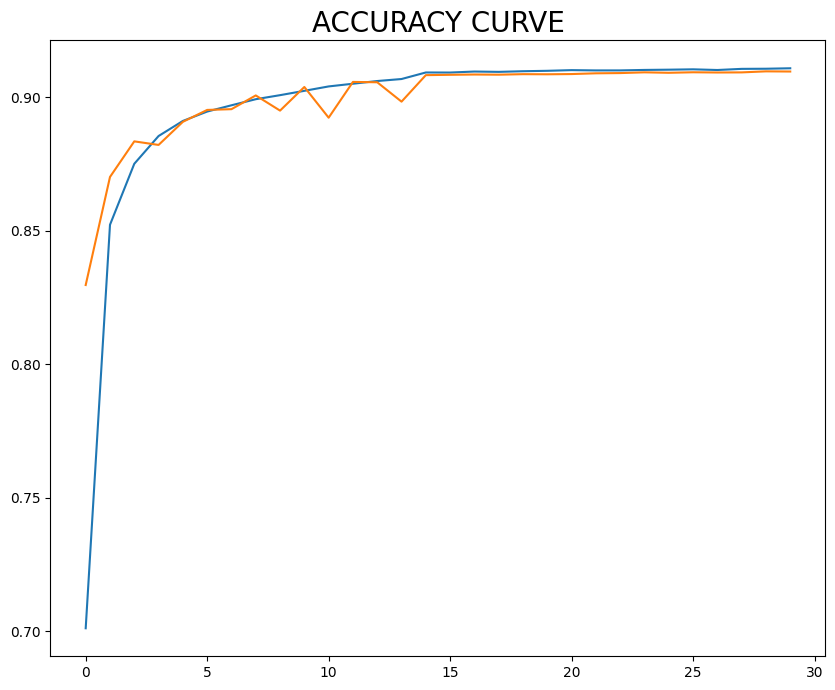

In [55]:
plt.figure(figsize=(10,8))
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('ACCURACY CURVE',fontdict={'size':20})
plt.show()

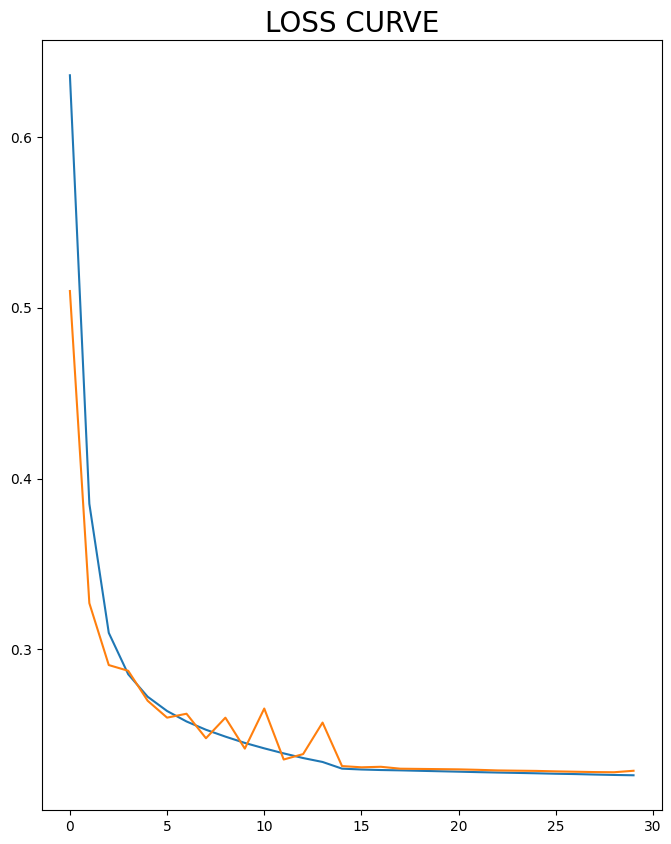

In [56]:
plt.figure(figsize=(8,10))
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('LOSS CURVE',fontdict={'size':20})
plt.show()

In [57]:
model.save('./model',overwrite=True)

INFO:tensorflow:Assets written to: ./model\assets


INFO:tensorflow:Assets written to: ./model\assets
